# Important note before running this code
This code assumes that the data preperation notebook was executed before and hence the sql database accessed underneath, is already populated

In [4]:
# Imports
from sqlalchemy import create_engine, inspect, Table
import pandas as pd
import numpy as np
import json
import country_converter as coco
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

In [5]:
# Open a connection to the postgresql database
db_conn = create_engine("postgresql://student:infomdss@db_dashboard:5432/covid")

In [6]:
df = pd.read_sql('SELECT * FROM cases',db_conn)
df.head()

ProgrammingError: (psycopg2.errors.UndefinedTable) relation "cases" does not exist
LINE 1: SELECT * FROM cases
                      ^

[SQL: SELECT * FROM cases]
(Background on this error at: https://sqlalche.me/e/14/f405)

In [82]:
class SQL_reader:
    def __init__(self, db_conn,mainView,ISO_filter = ['NLD','JPN','ITA']):
        self.db_conn = db_conn
        self.mainView = mainView
        self.ISO_filter = ISO_filter
    def GetIsoDict(self, kpiColNames, policyColName = 'event_cancellation_level', daysAhead = 14):
        """
        A method which reads a KPI from the SQL database for all countries specified in the ISO_filter distinctly.
        And makes them of equal length such that the Nth entry of the KPI array is the value of this KPI X days before
        the PER level of the Nth entry of the policy array, where X = daysAhead.
        The method returns a dictionary mapping the ISO code of each country to a (kpi, policy) pair for that country.
        """
        isoDict = dict()
        for iso in self.ISO_filter:
            queryP2 = ' FROM ' + self.mainView + '\nWHERE ' "iso_code = '" + iso + "';"
            policy = np.array(pd.read_sql('SELECT ' + policyColName + queryP2, self.db_conn)[policyColName])
            policy = policy[daysAhead:]
            kpis = []
            for kpiColName in kpiColNames:
                kpi = np.array(pd.read_sql('SELECT ' + kpiColName + queryP2, self.db_conn)[kpiColName])
                kpi = kpi[:-daysAhead]
                kpis.append(kpi)
            toDelete = []

            for i in range(len(policy)):
                if policy[i] == None or np.isnan(policy[i]): #Ugly code, first  condition should be dropped after data preprocessing makes sure missing values are encoded consistentl
                    toDelete.append(i)
                    continue
                for kpi in kpis:
                    if kpi[i] == None or np.isnan(kpi[i]): #Ugly code, first  condition should be dropped after data preprocessing makes sure missing values are encoded consistently
                        toDelete.append(i)
                        break
            for i in range(len(kpis)):
                kpis[i] = np.delete(kpis[i],toDelete)
            policy = np.delete(policy,toDelete)
            isoDict[iso] = (kpis,policy)
        return isoDict
    
    def FormatColumns(self, kpiColNames, policyColName = 'event_cancellation_level', daysAhead = 14):
        """
        A method which returns a kpi, policy pair of equal length such that the Nth entry of the KPI array is the value of this KPI X days before
        the PER level of the Nth entry of the policy array, where X = daysAhead. These arrays contain the values for all countries in the ISO_filter.
        """
        isoDict = self.GetIsoDict(kpiColNames,policyColName,daysAhead)
        
        kpis = []
        for i in range(len(list(isoDict.values())[0][0])):
            kpis.append([])
        policy = []
        for k, v in isoDict.items():
            kpiParts, policyPart = v
            for i in range(len(kpiParts)):
                kpis[i].extend(kpiParts[i])
            policy.extend(policyPart)
        return kpis, policy

In [68]:
class DescriptiveRelationAnalytics:
    """
    A class designed to perform descriptive analytics for the relation between
    all kpi's and our independent variable, being the public event restrictions (PER) level
    in place (an ordinal value with 5 levels).
    """
    def __init__(self, db_conn,mainView,ISO_filter = ['NLD','JPN','ITA']):
        self.sql = SQL_reader(db_conn,mainView,ISO_filter)
    def KPI_policy_covar(self, kpiColName, policyColName = 'event_cancellation_level', daysAhead = 14):
        """
        A method designed to find and return the covariance matrix between a given kpi and the PER level X days later,
        where X = daysAhead
        NOTE TO SELF: covariance between an ordinal and ratio value might not make sense, might need to delete this function
        """
        kpis, policy = self.sql.FormatColumns([kpiColName],policyColName,daysAhead)
        kpi = kpis[0]
        covar = np.cov(kpi,policy)
        return covar
    def KPI_policy_rho(self, kpiColName, policyColName = 'event_cancellation_level', daysAhead = 14):
        """
        A method designed to find and return Spearman's rank correlation coefficient, denoted as rho, 
        together with the corresponding p-value between given KPI measure and the PER level X days later, where X = daysAhead.
        """
        kpis, policy = self.sql.FormatColumns([kpiColName],policyColName,daysAhead)
        kpi = kpis[0]
        rho, p = spearmanr(kpi,policy)
        return (rho,p)
    
    def KPI_policy_plot(self, kpiColName, policyColName = 'event_cancellation_level', daysAhead = 14):
        """
        A method designed to plot the PER level against a given kpi X days earlier, where X = daysAhead, distinguishing between different countries.
        """
        isoDict = self.sql.GetIsoDict([kpiColName],policyColName,daysAhead)
        for iso, v in isoDict.items():
            kpis, policy = v
            kpi = kpis[0]
            plt.scatter(kpi,policy, marker = '.',alpha=0.2)
        plt.xlabel(kpiColName)
        plt.ylabel(policyColName)
        title = policyColName + ' for ' + kpiColName + ' ' + str(daysAhead) +' days before in '
        if len(self.sql.ISO_filter)==1:
            title += self.sql.ISO_filter[0]
        else:
            for iso in self.sql.ISO_filter[:-1]:
                title+= iso + ', '
            title = title[:-2]
            title += ' and ' + self.sql.ISO_filter[-1]
        plt.title(title)
        leg = [x + ' (N=' + str(len(isoDict[x][0])) + ')' for x in isoDict.keys()]
        plt.legend(leg)
        plt.yticks(np.arange(5),['No restrictions','> 1000 people','100-1000 people','10-100 people','< 10 people'])
        plt.show()

    def KPIs_policy_stats_and_plots(self, kpiColNameList, policyColName = 'event_cancellation_level', daysAhead = 14):
        """
        A method which provides and prints statistical data on the relation between a given list of KPIs and the PER level X days later, where X = daysAhead
        and plots their relation as well
        """
        for kpiName in kpiColNameList:
            print(kpiName)
            print('covariation:\n'+str(self.KPI_policy_covar(kpiName,policyColName,daysAhead)))
            rho, p = self.KPI_policy_rho(kpiName,policyColName,daysAhead)
            print('Pearson Rho: ' + str(rho) +'\t' + 'p: ' + str(p))
            self.KPI_policy_plot(kpiName,policyColName,daysAhead)
 
    
    

In [69]:
DRanalytics = DescriptiveRelationAnalytics(db_conn,'all_relevant')

In [70]:
DRanalytics.KPI_policy_rho('reproduction_rate')

[array([2.45, 2.38, 2.38, 2.43, 2.4 , 2.33, 2.27, 2.76, 2.7 , 2.58, 2.51,
       2.5 , 2.47, 2.21, 2.16, 2.09, 2.03, 2.01, 1.94, 1.86, 1.76, 1.65,
       1.55, 1.45, 1.36, 1.29, 1.22, 1.17, 1.15, 1.16, 1.15, 1.14, 1.13,
       1.13, 1.12, 1.11, 1.07, 1.04, 1.01, 0.97, 0.96, 0.96, 0.95, 0.93,
       0.9 , 0.87, 0.82, 0.78, 0.73, 0.7 , 0.67, 0.64, 0.61, 0.61, 0.61,
       0.62, 0.62, 0.62, 0.63, 0.65, 0.65, 0.66, 0.65, 0.65, 0.65, 0.65,
       0.65, 0.65, 0.64, 0.63, 0.64, 0.65, 0.68, 0.72, 0.77, 0.81, 0.82,
       0.84, 0.86, 0.88, 0.88, 0.87, 0.84, 0.83, 0.82, 0.83, 0.83, 0.86,
       0.9 , 0.99, 1.05, 1.08, 1.09, 1.07, 1.05, 1.02, 0.98, 0.97, 0.94,
       0.9 , 0.88, 0.83, 0.77, 0.71, 0.67, 0.65, 0.65, 0.66, 0.69, 0.72,
       0.74, 0.74, 0.73, 0.73, 0.75, 0.76, 0.76, 0.77, 0.78, 0.76, 0.76,
       0.75, 0.78, 0.81, 0.87, 0.95, 1.06, 1.14, 1.19, 1.24, 1.32, 1.38,
       1.43, 1.49, 1.53, 1.58, 1.55, 1.49, 1.45, 1.43, 1.43, 1.47, 1.47,
       1.51, 1.55, 1.6 , 1.63, 1.64, 1.61, 1.61, 1

(0.0632440051910639, 0.0007584955963373388)

In [46]:
kpis = ['new_cases_smoothed_per_million','reproduction_rate','icu_patients_per_million','hosp_patients_per_million','weekly_icu_admissions_per_million',
        'people_fully_vaccinated_per_hundred', 'total_boosters_per_hundred','new_vaccinations_smoothed_per_million']

new_cases_smoothed_per_million
covariation:
[[ 4.70752476e+05 -8.35313692e+01]
 [-8.35313692e+01  2.62105994e+00]]
Pearson Rho: 0.11038757979872434	p: 2.8932629882402893e-09


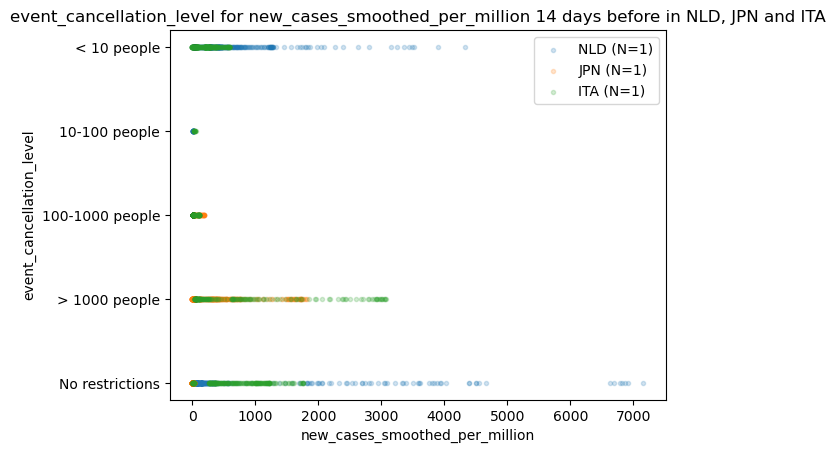

reproduction_rate
covariation:
[[0.14863139 0.03918488]
 [0.03918488 2.60051648]]
Pearson Rho: 0.0632440051910639	p: 0.0007584955963373388


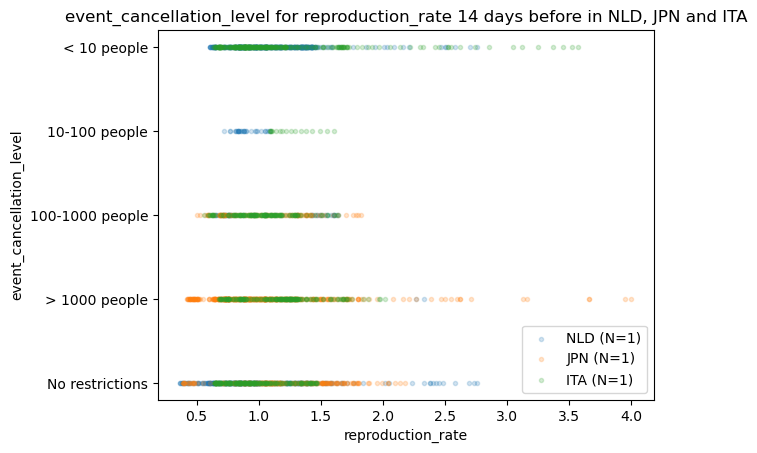

icu_patients_per_million
covariation:
[[322.01431312  20.14562635]
 [ 20.14562635   3.00435381]]
Pearson Rho: 0.5768994227857394	p: 3.317677230390039e-174


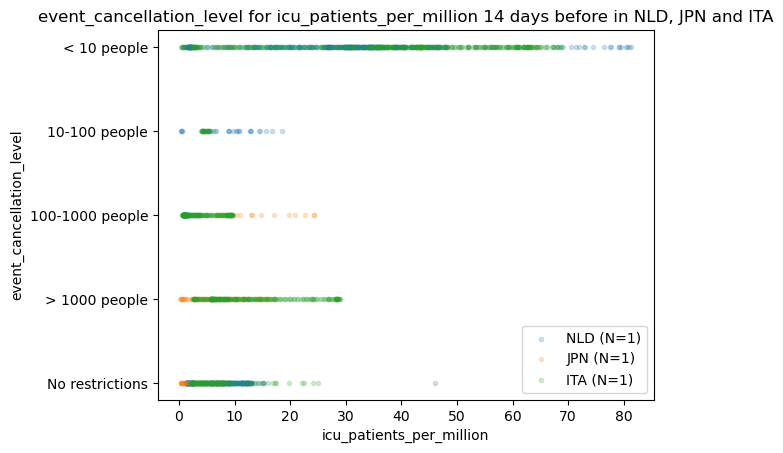

hosp_patients_per_million
covariation:
[[2.03089551e+04 8.06431068e+01]
 [8.06431068e+01 3.00510985e+00]]
Pearson Rho: 0.25017442488900066	p: 2.3702224848594802e-29


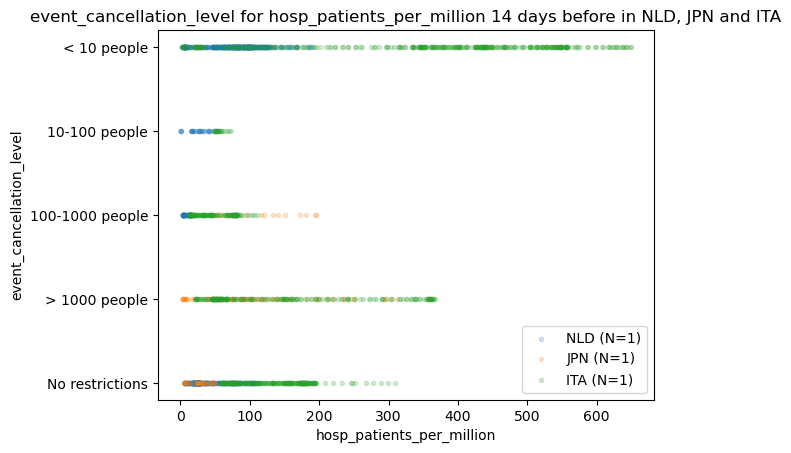

weekly_icu_admissions_per_million
covariation:
[[50.11968071  9.10312366]
 [ 9.10312366  3.35095386]]
Pearson Rho: 0.672338468674905	p: 1.248916346303744e-171


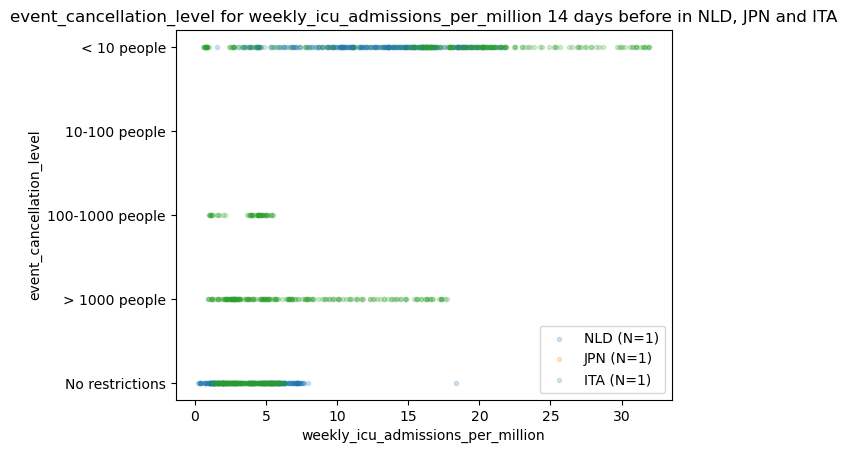

people_fully_vaccinated_per_hundred
covariation:
[[941.62598634 -28.33350653]
 [-28.33350653   1.62739409]]
Pearson Rho: -0.6483620086953252	p: 2.996093917373702e-154


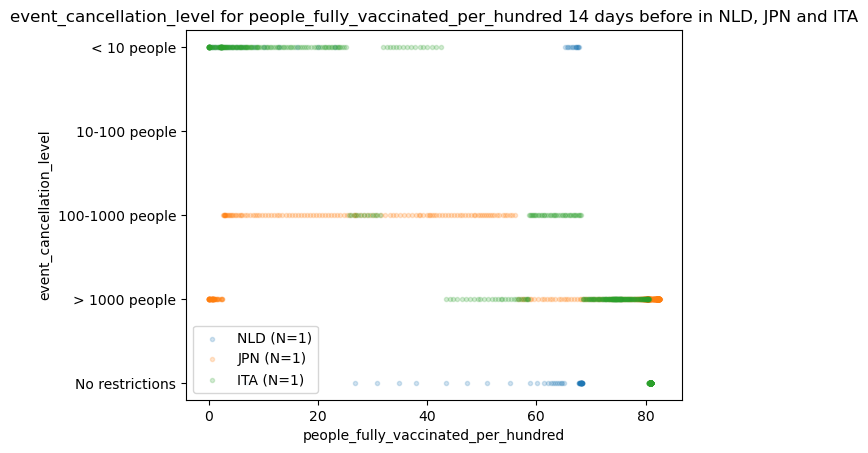

total_boosters_per_hundred
covariation:
[[ 8.28522456e+02 -8.07214422e+00]
 [-8.07214422e+00  4.29651778e-01]]
Pearson Rho: -0.5115261989304688	p: 1.0274167099597052e-50


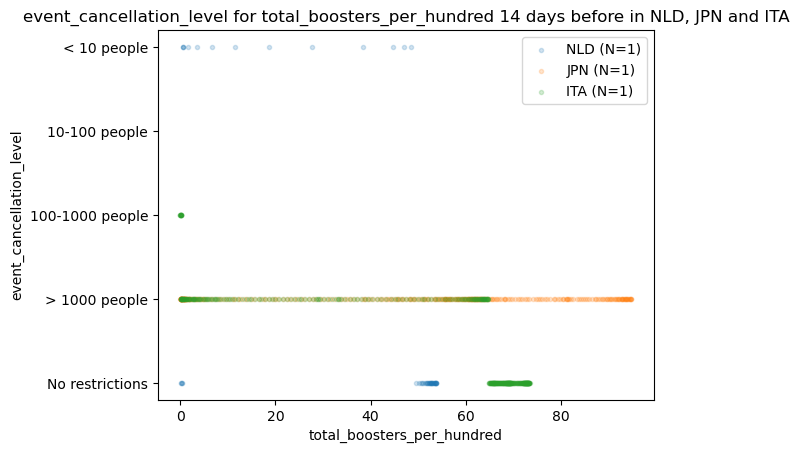

new_vaccinations_smoothed_per_million
covariation:
[[1.27784669e+07 1.59136413e+03]
 [1.59136413e+03 2.26860815e+00]]
Pearson Rho: 0.4598390088987887	p: 5.490631079865911e-97


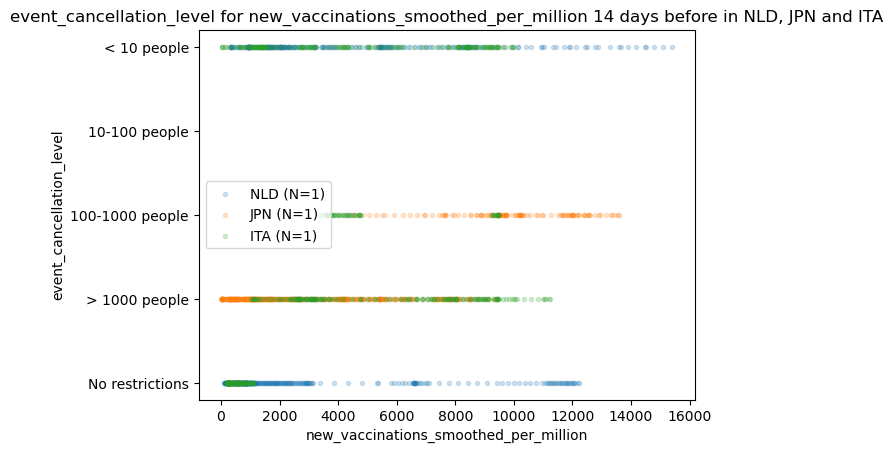

In [47]:

DRanalytics.KPIs_policy_stats_and_plots(kpis)

# Towards predictive analytics

In [176]:
from sklearn.neighbors import KNeighborsClassifier as KNC
from sklearn.model_selection import train_test_split

In [256]:
class MajorityBaseline:
    def __init__(self):
        self.choice = 0
    def fit(self,X,Y):
        N = len(np.unique(Y))
        Count = []
        for i in range(N):
            Count.append(0)
        for y in Y:
            for i in range(N):
                if y == i:
                    Count[i] += 1
                    break
        maxCount = max(Count)
        print(Count)
        print(maxCount)
        self.choice = [i for i in range(len(Count)) if Count[i]==maxCount][0]
    def predict(self, X):
        return np.array([self.choice for x in X])
    def score(self, X, Y):
        right = 0
        Y_hat = self.predict(X)
        for i in range(len(Y)):
            if Y_hat[i] == Y[i]:
                right += 1
        return right/len(Y)

In [257]:
class PredictiveAnalytics:
    def __init__(self, db_conn,mainView, selectedKPIs, ISO_filter = ['NLD','JPN','ITA'], policyColName = 'event_cancellation_level', daysAhead = 14):
        self.sql = SQL_reader(db_conn,mainView,ISO_filter)
        self.KPIs = selectedKPIs
        X, Y = self.sql.FormatColumns(self.KPIs,policyColName,daysAhead)
        X =np.array(X)
        Y = np.array(Y)
        
        M = []
        S = []
        for x in X:
            M.append([np.mean(x)])
            S.append([np.std(x,ddof=1)])
        M = np.array(M)
        S = np.array(S)
        X = ((X - M)/S+1)/2
        X=X.T

        
        self.X = X
        self.Y = Y
        
    def getMeanAndSD(kpi):
        m = np.mean(kpi)
        s = np.std(kpi,ddof=1)
        return m,s
    
    def PredictKNN(self, X, k = 5):
        knn = KNC(n_neighbors = k)
        knn.fit(self.X, self.Y)
        return knn.predict(X)
    
    def TestModels(self, modelDict):
        # Split into training and test set
        X_train, X_test, Y_train, Y_test = train_test_split(self.X, self.Y, test_size = 0.2, random_state=42)
        scoreDict = dict()
        for key, value in modelDict.items():
            value.fit(X_train, Y_train)
            scoreDict[key] = value.score(X_test,Y_test)
        return scoreDict
    



In [271]:
PrAn = PredictiveAnalytics(db_conn,'all_relevant',kpis)

In [273]:
N = [0,0,0,0,0]
for y in PrAn.Y:
    for i in range(5):
        if y == i:
            N[i] += 1
            break
print('Y data distribution:')
for i in range(5):
    print(str(i) + ': ' + str(N[i]))

Y data distribution:
0: 235
1: 174
2: 12
3: 0
4: 13


In [274]:

modelDict = dict()
modelDict['knn model (k=1)'] =  KNC(n_neighbors = 1)
modelDict['knn model (k=2)'] =  KNC(n_neighbors = 2)
modelDict['knn model (k=5)'] = KNC(n_neighbors = 5)
modelDict['knn model (k=10)'] = KNC(n_neighbors = 10)
mb = MajorityBaseline()
modelDict['Majority baseline'] = mb
x = PrAn.TestModels(modelDict)
print(x)

[183, 144, 9, 0]
183
{'knn model (k=1)': 0.9885057471264368, 'knn model (k=2)': 0.9885057471264368, 'knn model (k=5)': 0.9885057471264368, 'knn model (k=10)': 0.9770114942528736, 'Majority baseline': 0.5977011494252874}


In [275]:
809/(581+283+230+47+809)

0.4148717948717949

In [276]:
mb.choice

0